In [1]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()
pose_label = pose.LIPLabel(root /'pose_annotations')
transforms = [pose.pose_flip_lr(p=0.5)], None
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [3]:
class NoOpInstuctor(cs.BaseInstructor):
    def __init__(self, n_iter):
        self.n_iter = 0
        self. i = 0
    
    def on_batch_begin(self, **kwargs):
        self.i = 0
        
    def next_inst(self, bu_out):
        self.i += 1
        should_continue = self.i < self.n_iter
        return None, should_continue


def loss(outputs, targets):
    bu, td = outputs
    is_visible = targets[..., 2] > 0
    bu_loss = F.binary_cross_entropy_with_logits(bu, is_visible.float())
    
    gt = targets[is_visible][..., :2]
    td_loss = pose.ce_loss(td[is_visible], gt)
    return bu_loss + td_loss

In [4]:
nk = 16
thresh = 0.8
def acc(last_output, last_target):
    return accuracy_thresh(last_output[0], last_target[..., 2].clamp(0, 1), thresh=thresh)
acc.__name__ = f'accuracy@{thresh}'

In [10]:
instructor = NoOpInstuctor(1)
learner = cs.cs_learner(data, models.resnet18, nk, instructor, bu_c=nk, td_laterals=False, embedding=None,
                        loss_func=loss, callback_fns=pose.Pckh, metrics=acc)

In [9]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02
Min loss divided by 10: 3.63E-02


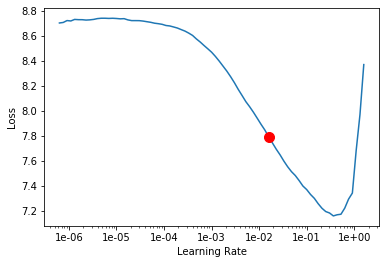

In [10]:
learner.recorder.plot(suggestion=True)

In [11]:
lr = 3e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.452271,4.191381,0.850375,0.821554,0.648885,0.446394,0.402224,0.410092,0.406420,0.466261,0.584769,0.523387,01:04
1,4.323116,3.999547,0.870856,0.828611,0.681655,0.512697,0.451326,0.460060,0.441508,0.478596,0.623154,0.560329,00:54
2,4.211949,4.031713,0.801106,0.829693,0.688488,0.528976,0.459827,0.426052,0.446093,0.477063,0.631194,0.560584,00:56
3,4.085063,4.164949,0.689831,0.842932,0.684411,0.504191,0.437776,0.327984,0.318911,0.362641,0.622285,0.512130,00:54
4,3.917750,3.650973,0.820669,0.859880,0.739141,0.597154,0.549438,0.519954,0.523154,0.541444,0.690280,0.627744,00:54
5,3.846393,3.668953,0.753950,0.866938,0.747505,0.617159,0.569274,0.532834,0.544172,0.552041,0.703849,0.641827,00:56
6,3.731841,3.489691,0.839037,0.874459,0.764575,0.634461,0.593811,0.547560,0.575217,0.567697,0.720250,0.659725,00:54
7,3.636676,3.393422,0.828963,0.879095,0.777105,0.658338,0.611758,0.569408,0.590883,0.592439,0.734848,0.676635,00:54
8,3.524392,3.365403,0.830856,0.879920,0.783110,0.673258,0.627539,0.577488,0.603936,0.596604,0.744063,0.685625,00:55
9,3.459114,3.332067,0.854894,0.881517,0.785511,0.674474,0.629181,0.580228,0.604777,0.599313,0.745786,0.687496,00:50


In [12]:
learner.save('no_inst-stage1', return_path=True)

PosixPath('/home/labs/waic/omrik/LIP/models/no_inst-stage1.pth')

In [13]:
learner.load('no_inst-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CounterStream(
  (bu_body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

In [14]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.10E-05


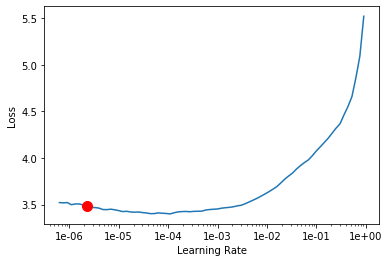

In [15]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [16]:
learner.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.470848,3.342680,0.845250,0.880229,0.784674,0.671600,0.628535,0.577776,0.599674,0.597069,0.744371,0.685370,00:56
1,3.494806,3.347897,0.876619,0.881362,0.785881,0.668858,0.626706,0.574002,0.607288,0.598682,0.743850,0.685609,00:53
2,3.493695,3.346057,0.855694,0.879611,0.789008,0.675023,0.629439,0.577707,0.607861,0.598162,0.746361,0.687735,00:56
3,3.415424,3.345441,0.833325,0.882289,0.794803,0.674030,0.628653,0.588426,0.617420,0.610600,0.748137,0.692976,00:55
4,3.345321,3.303083,0.900769,0.884917,0.795060,0.684779,0.640233,0.588039,0.619869,0.614159,0.754267,0.697384,00:53
5,3.277038,3.286951,0.861756,0.886359,0.801281,0.693521,0.641647,0.598202,0.630745,0.623683,0.758701,0.704035,00:56
6,3.162181,3.314198,0.876581,0.881774,0.805665,0.697470,0.645771,0.601857,0.633370,0.625133,0.760598,0.706243,00:51
7,3.091640,3.305130,0.868131,0.884762,0.804778,0.696564,0.650909,0.603110,0.633902,0.630871,0.762160,0.708072,00:50
8,3.024091,3.315723,0.872537,0.884195,0.806190,0.701065,0.649241,0.607928,0.636527,0.632787,0.763082,0.709902,00:51
9,3.002730,3.323679,0.871750,0.884092,0.804831,0.701067,0.648693,0.604481,0.636265,0.632793,0.762574,0.709037,00:51


In [17]:
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=32)
        .normalize(imagenet_stats))

learner.data = data

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 4.37E-04


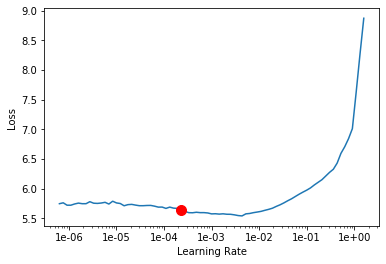

In [18]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [19]:
learner.fit_one_cycle(20, slice(2e-4, lr/5))

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.517324,4.170666,0.843231,0.900474,0.816937,0.720390,0.691714,0.583878,0.620342,0.602400,0.784972,0.714508,01:14
1,4.428141,4.110897,0.866606,0.905728,0.820751,0.725726,0.695999,0.596946,0.647952,0.628312,0.789633,0.725583,01:13
2,4.460902,4.141013,0.892263,0.906192,0.814911,0.723730,0.700591,0.600268,0.659137,0.639828,0.788885,0.728262,01:20
3,4.405343,4.099556,0.872669,0.902277,0.824881,0.721370,0.687949,0.608251,0.660283,0.631868,0.786788,0.727462,01:17
4,4.384222,4.152974,0.860400,0.906656,0.815164,0.713570,0.683621,0.594912,0.634925,0.611027,0.782501,0.717409,01:19
5,4.303541,4.073477,0.834481,0.907531,0.830516,0.738378,0.705470,0.623663,0.668006,0.648702,0.797954,0.739444,01:18
6,4.264496,4.103704,0.855075,0.906244,0.829945,0.742470,0.701740,0.629616,0.672774,0.657135,0.797580,0.741611,01:16
7,4.199483,4.019840,0.881581,0.910880,0.836780,0.755878,0.714080,0.631610,0.688721,0.686775,0.806782,0.752744,01:15
8,4.103187,3.975470,0.904194,0.913353,0.843102,0.762213,0.724062,0.644158,0.702106,0.687474,0.812979,0.760218,01:17
9,4.015633,3.982273,0.883375,0.912116,0.844512,0.764616,0.730659,0.648035,0.704813,0.692882,0.815183,0.763078,01:19


epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-07


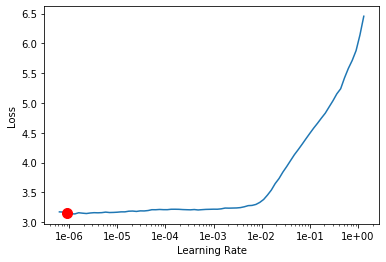

In [20]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [21]:
learner.fit_one_cycle(10, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.223159,4.213285,0.879950,0.913249,0.851562,0.778118,0.740602,0.652304,0.719676,0.715483,0.822983,0.772810,01:13
1,3.247292,4.231679,0.880050,0.914022,0.852345,0.777476,0.738806,0.647928,0.716331,0.715861,0.822796,0.771656,01:13
2,3.243408,4.239217,0.881075,0.912374,0.849998,0.775392,0.737431,0.649190,0.716074,0.715173,0.820926,0.770585,01:13
3,3.226607,4.264828,0.878675,0.911395,0.849837,0.772127,0.736407,0.644050,0.713183,0.711838,0.819590,0.768269,01:13
4,3.172132,4.311548,0.872163,0.910313,0.848846,0.774891,0.733854,0.637602,0.711747,0.709060,0.819123,0.766530,01:13
5,3.157642,4.364028,0.866800,0.909695,0.847383,0.772270,0.734122,0.639353,0.710566,0.710453,0.818014,0.766110,01:13
6,3.105639,4.409286,0.864606,0.910365,0.848376,0.772072,0.732852,0.635966,0.710630,0.709070,0.818081,0.765500,01:13
7,3.081824,4.432942,0.880581,0.910983,0.847488,0.773022,0.733449,0.638199,0.710953,0.709448,0.818388,0.766110,01:13
8,3.062099,4.461591,0.876650,0.909180,0.846341,0.771693,0.732801,0.635258,0.708603,0.708059,0.817146,0.764454,01:13
9,3.035265,4.473680,0.888969,0.909489,0.846079,0.771261,0.732724,0.636560,0.710561,0.707204,0.817039,0.764742,01:13


## Detach

In [5]:
root = Path('../../LIP').resolve()
pose_label = pose.LIPLabel(root /'pose_annotations')
transforms = [pose.pose_flip_lr(p=0.5)], None
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [8]:
instructor = NoOpInstuctor(1)
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=nk, bu_c=nk, td_laterals=False, embedding=None,
                        detach=True, loss_func=loss, callback_fns=pose.Pckh, metrics=acc)

In [9]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-03
Min loss divided by 10: 2.51E-02


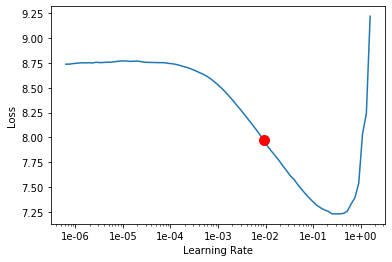

In [10]:
learner.recorder.plot(suggestion=True)

In [11]:
lr = 2.5e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.509336,4.207140,0.802831,0.795384,0.620886,0.436944,0.399975,0.418808,0.390621,0.455998,0.568141,0.511355,00:50
1,4.417598,4.690075,0.702444,0.761333,0.547791,0.366632,0.348761,0.329048,0.371102,0.350317,0.510965,0.448843,00:49
2,4.346249,4.235368,0.699337,0.810066,0.635991,0.458031,0.409280,0.400827,0.394880,0.462363,0.583126,0.519126,00:50
3,4.226136,3.923800,0.814994,0.825314,0.702805,0.514686,0.483191,0.465950,0.454313,0.489846,0.635828,0.571857,00:50
4,4.088720,3.813281,0.862181,0.847208,0.698736,0.529038,0.494673,0.451197,0.473802,0.498620,0.646780,0.579768,00:50
5,3.991646,3.770464,0.727831,0.851020,0.720301,0.577405,0.538234,0.494103,0.495097,0.510270,0.675548,0.607901,00:50
6,3.843786,3.560944,0.851131,0.861220,0.746241,0.618308,0.565879,0.522576,0.540257,0.538058,0.701512,0.636850,00:50
7,3.744458,3.517417,0.834456,0.867659,0.761862,0.633689,0.584506,0.537326,0.561510,0.555375,0.715415,0.652169,00:50
8,3.656461,3.439337,0.855987,0.872811,0.764994,0.644283,0.596245,0.549017,0.576791,0.564052,0.722961,0.661431,00:50
9,3.601371,3.443670,0.839338,0.872244,0.766614,0.644989,0.599271,0.549729,0.575543,0.564908,0.724123,0.662189,00:50


In [12]:
learner.save('no_inst-detach-stage1', return_path=True)

PosixPath('/home/labs/waic/omrik/LIP/models/no_inst-detach-stage1.pth')

In [13]:
learner.load('no_inst-detach-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CounterStream(
  (bu_body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

In [14]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.75E-05


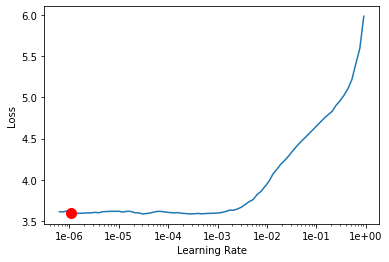

In [15]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [16]:
learner.fit_one_cycle(20, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.621946,3.434081,0.853031,0.871523,0.767503,0.646703,0.600397,0.552135,0.573318,0.564984,0.724858,0.662733,00:51
1,3.629149,3.459887,0.847637,0.871471,0.765834,0.640623,0.594464,0.543337,0.565588,0.564128,0.721505,0.658275,00:50
2,3.637094,3.528300,0.784662,0.868432,0.767611,0.643871,0.594891,0.541902,0.569374,0.561794,0.722066,0.658638,00:50
3,3.670631,3.464994,0.842450,0.868123,0.762912,0.636131,0.593214,0.540060,0.572589,0.561729,0.718500,0.656553,00:50
4,3.675406,3.484942,0.857463,0.872811,0.759303,0.637960,0.595471,0.529557,0.567080,0.552747,0.719756,0.654097,00:50
5,3.639151,3.477513,0.838456,0.868741,0.768498,0.643183,0.595383,0.540328,0.561856,0.562976,0.722320,0.657731,00:50
6,3.617956,41.602608,0.857988,0.861065,0.752000,0.636263,0.587876,0.533166,0.560187,0.546429,0.712597,0.648683,00:50
7,3.575152,3.480302,0.870306,0.870441,0.765149,0.643812,0.597660,0.541516,0.577122,0.574183,0.722601,0.661200,00:50
8,3.549199,3.514405,0.849194,0.869771,0.765882,0.642841,0.596312,0.539890,0.579043,0.570535,0.722080,0.660484,00:50
9,3.503050,3.423961,0.870319,0.872347,0.768442,0.649110,0.605549,0.549289,0.588417,0.581136,0.727142,0.667331,00:50
